In [ ]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu
from jax.config import config

from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
%matplotlib inline

In [ ]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [ ]:
# Define MLP
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

def modified_MLP_trunk(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, paras_branch, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      n = 0
      for W, b in params[:-1]:
          # outputs = np.dot(paras_branch[:,:,n*100:(n+1)*100], activation(np.dot(inputs, W) + b))
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)
          n += 1
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      outputs = paras_branch * outputs
      return outputs
  return init, apply


In [ ]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP_trunk(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                          decay_steps=2000,
                          decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x,t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, B, y)
        outputs = np.sum(T)
        return   outputs

    # Define PDE residual
    def residual_net(self, params, u, x, t, ux):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)

        res = s_t + ux * s_x
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y  = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, u, y[:,0], y[:,1], y[:,2])
        # Compute loss
        loss = np.mean((pred)**2)
        return loss

    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = 100 * loss_bcs +  loss_res
        return loss


    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                          'loss_bcs' : loss_bcs_value,
                          'loss_physics': loss_res_value})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

In [ ]:
from jax import devices
print(devices())

[gpu(id=0)]


In [ ]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)


# Deinfe initial and boundary conditions for advection equation
# IC: f(x, 0)  = sin(pi x)
# BC: g(0, t) = sin (pi t / 2)
f = lambda x: np.sin(np.pi * x)
g = lambda t: np.sin(np.pi * t/2)

# Advection solver
def solve_CVC(key, gp_sample, Nx, Nt, m, P):
    # Solve u_t + a(x) * u_x = 0
    # Wendroff for a(x)=V(x) - min(V(x)+ + 1.0, u(x,0)=f(x), u(0,t)=g(t)  (f(0)=g(0))
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1

    N = gp_sample.shape[0]
    X = np.linspace(xmin, xmax, N)[:,None]
    V = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    lam = dt / h

    # Compute advection velocity
    v_fn = lambda x: V(x) - V(x).min() + 1.0
    v =  v_fn(x)

    # Initialize solution and apply initial & boundary conditions
    u = np.zeros([Nx, Nt])
    u = u.at[0, :].set(g(t))
    u = u.at[:, 0].set(f(x))

    # Compute finite difference operators
    a = (v[:-1] + v[1:]) / 2
    k = (1 - a * lam) / (1 + a * lam)
    K = np.eye(Nx - 1, k=0)
    K_temp = np.eye(Nx - 1, k=0)
    Trans = np.eye(Nx - 1, k=-1)
    def body_fn_x(i, carry):
        K, K_temp = carry
        K_temp = (-k[:, None]) * (Trans @ K_temp)
        K += K_temp
        return K, K_temp
    K, _ = lax.fori_loop(0, Nx-2, body_fn_x, (K, K_temp))
    D = np.diag(k) + np.eye(Nx - 1, k=-1)

    def body_fn_t(i, u):
        b = np.zeros(Nx - 1)
        b = b.at[0].set(g(i * dt) - k[0] * g((i + 1) * dt))
        u = u.at[1:, i + 1].set(K @ (D @ u[1:, i] + b))
        return u
    UU = lax.fori_loop(0, Nt-1, body_fn_t, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = v_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(key, (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]

    return (x, t, UU), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):

    subkeys = random.split(key, 10)
    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))

    v_fn = lambda x: np.interp(x, X.flatten(), gp_sample)
    u_fn = lambda x: v_fn(x) - v_fn(x).min() + 1.0

    (x, t, UU), (u, y, s) = solve_CVC(subkeys[1], gp_sample, Nx, Nt, m, P)

    x_bc1 = np.zeros((P // 2, 1))
    x_bc2 = random.uniform(subkeys[2], shape = (P // 2, 1))
    x_bcs = np.vstack((x_bc1, x_bc2))

    t_bc1 = random.uniform(subkeys[3], shape = (P//2, 1))
    t_bc2 = np.zeros((P//2, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    u_train = np.tile(u, (P, 1))
    y_train = np.hstack([x_bcs, t_bcs])

    s_bc1 = g(t_bc1)
    s_bc2 = f(x_bc2)
    s_train =  np.vstack([s_bc1, s_bc2])

    x_r = random.uniform(subkeys[4], shape=(Q,1), minval=xmin, maxval=xmax)
    t_r = random.uniform(subkeys[5], shape=(Q,1), minval=tmin, maxval=tmax)
    ux_r = u_fn(x_r)

    u_r_train = np.tile(u, (Q,1))
    y_r_train = np.hstack([x_r, t_r, ux_r])
    s_r_train = np.zeros((Q, 1))

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, Nx, Nt, P):
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    (x, t, UU), (u, y, s) = solve_CVC(key, gp_sample, Nx, Nt, m, P)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (Nx*Nt,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P, Q)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, Nx, Nt, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None, None, None))(keys, Nx, Nt, P)

    u_test = np.float32(u_test.reshape(N * Nx * Nt,-1))
    y_test = np.float32(y_test.reshape(N * Nx * Nt,-1))
    s_test = np.float32(s_test.reshape(N * Nx * Nt,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

# Compute relative l2 error over N test samples.
def compute_error(key, Nx, Nt, P):
    u_test, y_test, s_test = generate_test_data(key, 1, Nx, Nt, P)
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error_s = np.linalg.norm(s_test - s_pred, 2) / np.linalg.norm(s_test, 2)
    return error_s

In [ ]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

# Computational domain
xmin = 0.0
xmax = 1.0

tmin = 0.0
tmax = 1.0

N = 1000 # number of input samples
m = Nx   # number of input sensors
P_train = 200   # number of output sensors, 100 for each side
Q_train = 2000  # number of collocation points for each input sample

# Generate training data
u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train = generate_training_data(key, N, P_train, Q_train)

In [ ]:
# Initialize model
branch_layers = [m, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100]

model = PI_DeepONet(branch_layers, trunk_layers)

In [ ]:
import jax
from jax.tree_util import tree_flatten
def count_parameters(params):
    leaves, _ = tree_flatten(params)
    return sum(jax.numpy.size(leaf) for leaf in leaves)

# Assuming 'model' is an instance of your PI_DeepONet
model = PI_DeepONet(branch_layers, trunk_layers)
# Initialize or load the parameters of the model if not done already
print(count_parameters(model.get_params(model.opt_state)))

132200


In [ ]:
# Create data set
batch_size = 10000
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [ ]:
# Train
# Note: may meet OOM issue if use Colab. Please train this model on the server.
model.train(bcs_dataset, res_dataset, nIter=300000)

100%|██████████| 300000/300000 [2:06:11<00:00, 39.62it/s, Loss=0.016821582, loss_bcs=1.6069424e-05, loss_physics=0.015214639]


In [ ]:
params = model.get_params(model.opt_state)
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Advection')
# Save the trained model
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
np.save('adv_params_old.npy', flat_params)
np.save('adv_loss_res_old.npy', model.loss_log)
np.save('adv_loss_res_old.npy', model.loss_res_log)
np.save('adv_loss_bcs_old.npy', model.loss_bcs_log)

# Restore the trained model
flat_params = np.load('adv_params_old.npy')
params = model.unravel_params(flat_params)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


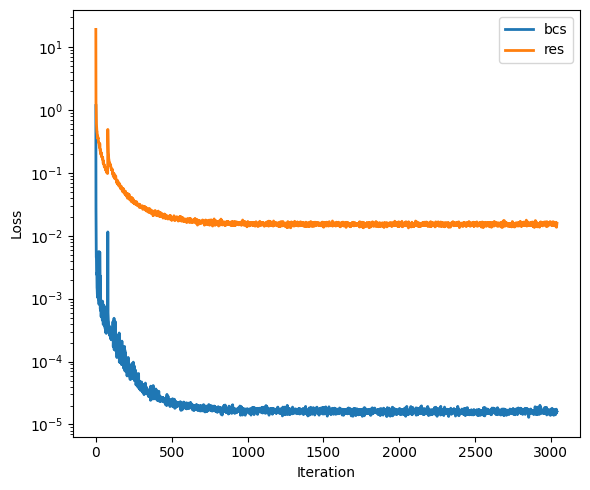

In [ ]:
# loss_bcs_log = model.loss_bcs_log
# loss_res_log = model.loss_res_log

# Restore losses
loss_bcs_log = np.load('adv_loss_bcs_old.npy')
loss_res_log = np.load('adv_loss_res_old.npy')

#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(loss_bcs_log, lw=2, label='bcs')
plt.plot(loss_res_log, lw=2, label='res')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Test data over 100 random input samples
N_test = 10
P_test = m

key_test = random.PRNGKey(7654321)
subkeys_test = random.split(key_test, N_test)

# Compute test error
error_list = []
for k in range(10):
    keys_test = random.split(subkeys_test[k], N_test)
    error_s = vmap(compute_error, (0, None, None, None))(keys_test, Nx, Nt, P_test)
    error_list.append(error_s)

error = np.stack(error_list)

print('mean of relative L2 error of s: {:.2e}'.format(error.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error.std()))

mean of relative L2 error of s: 4.28e-02
std of relative L2 error of s: 1.27e-02


In [ ]:
# Compute relative l2 error for one random input sample

key = keys_test[1]
length_scale= 0.2

P_test = 100
Nx = 200
Nt = 200

N_test = 1
u_test, y_test, s_test = generate_test_data(key, N_test, Nx, Nt, P_test)

# Predict
s_pred = model.predict_s(params, u_test, y_test)

# Evulate solution at a uniform grid
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

error = np.linalg.norm(S_pred - S_test) / np.linalg.norm(S_test)
print('Relative l2 errpr: {:.3e}'.format(error))

Relative l2 errpr: 3.807e-02


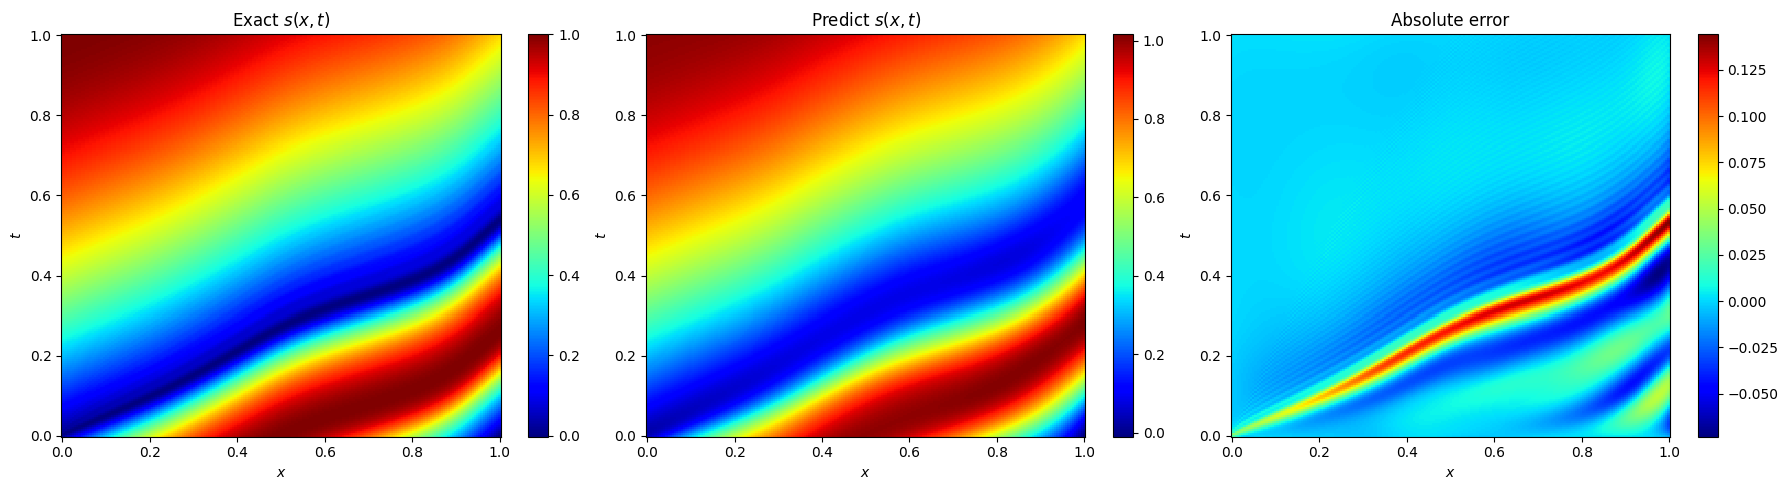

In [ ]:
# Visualization
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.colorbar()
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.show()